
Datasets Loaded Successfully!

                        File Name  Rows  Columns
0  Ashvin_5Mins_NB_20_02_2025.csv  5884        6
1     Harsha_5min_NB_20_02_25.csv  9791        6


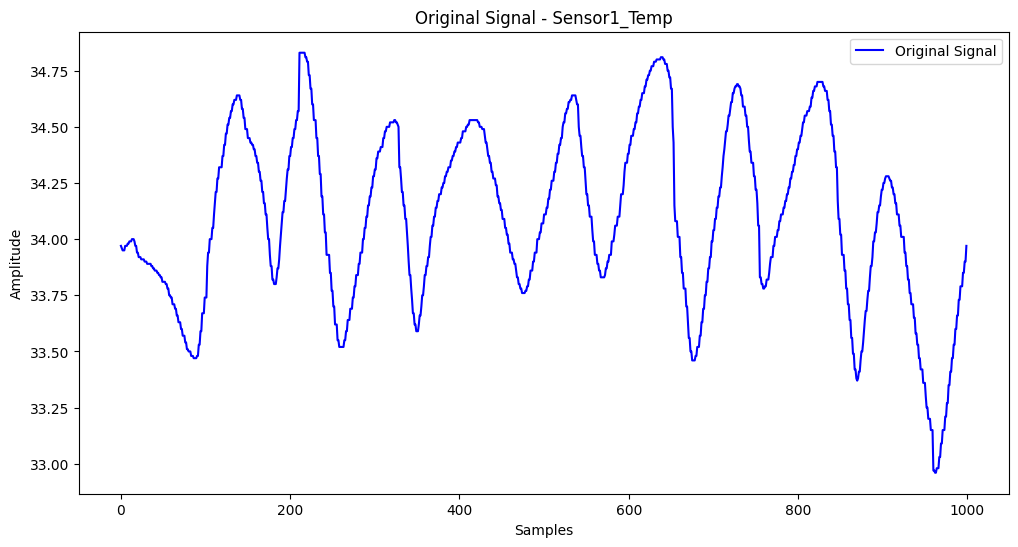

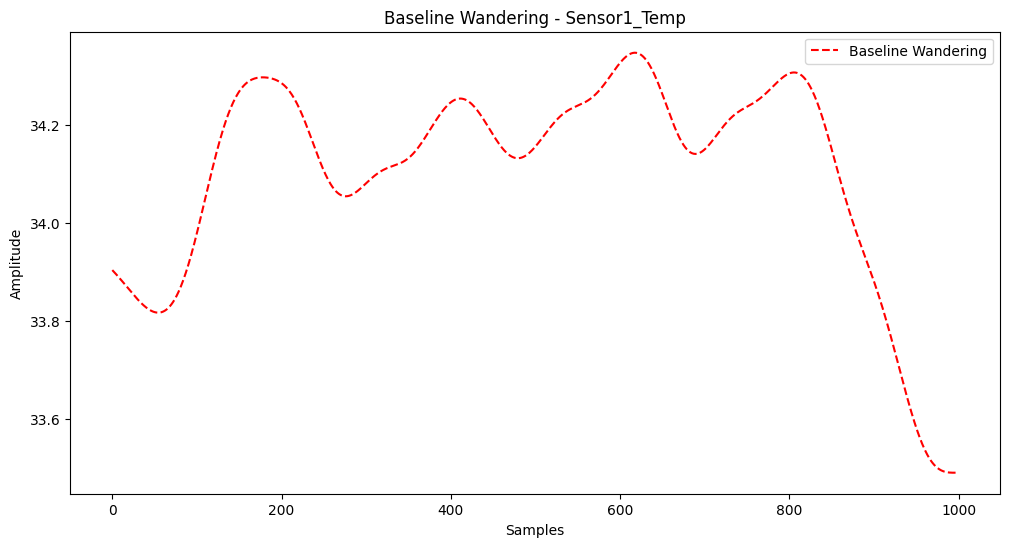

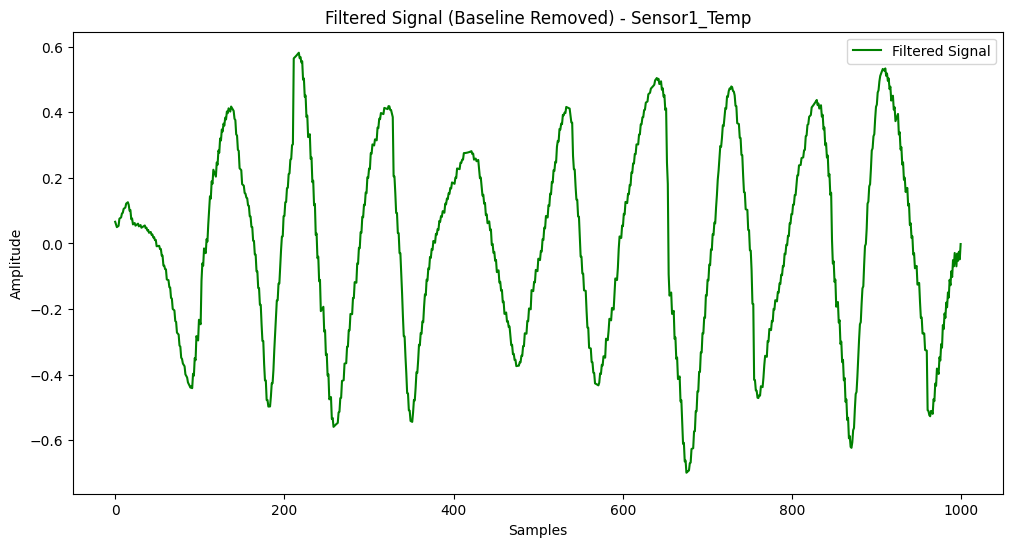

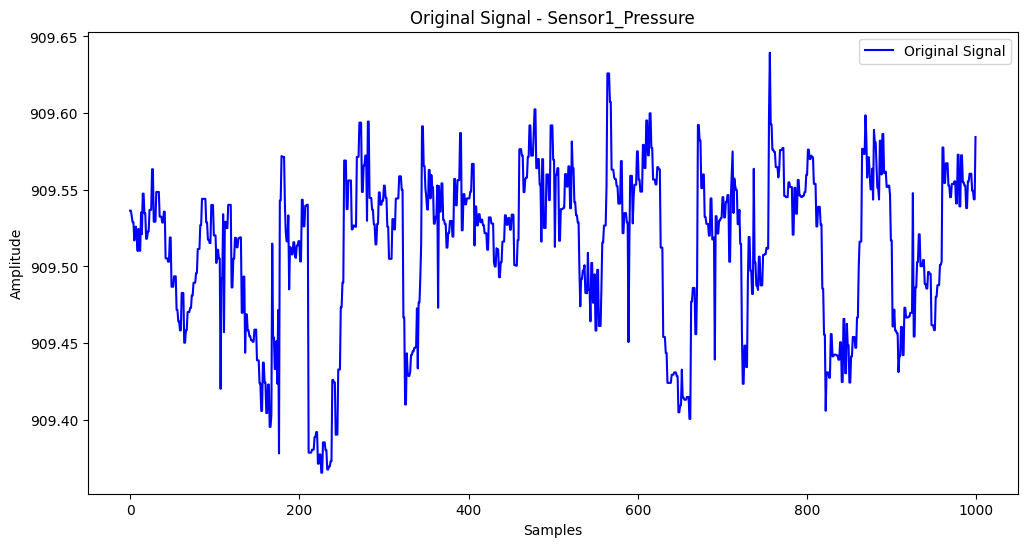

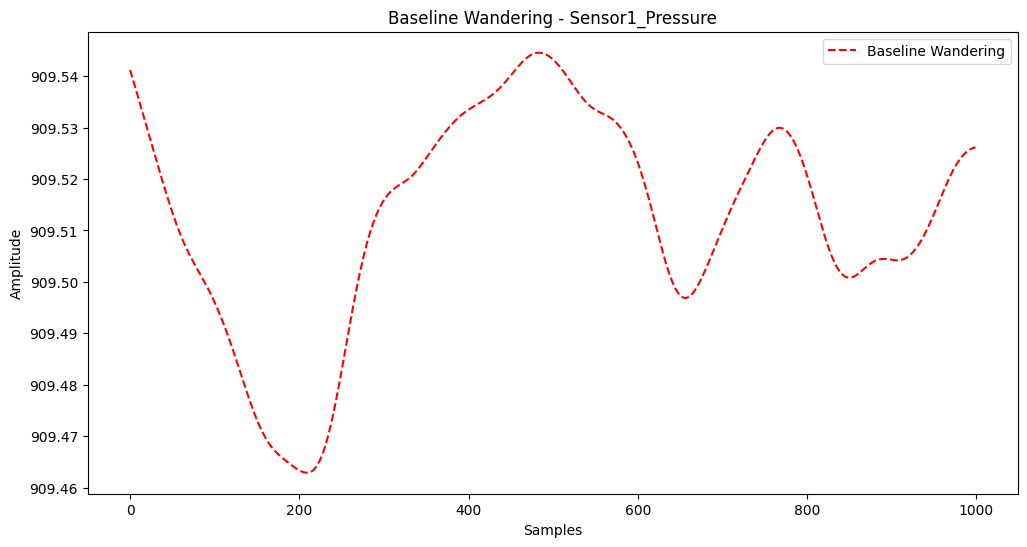

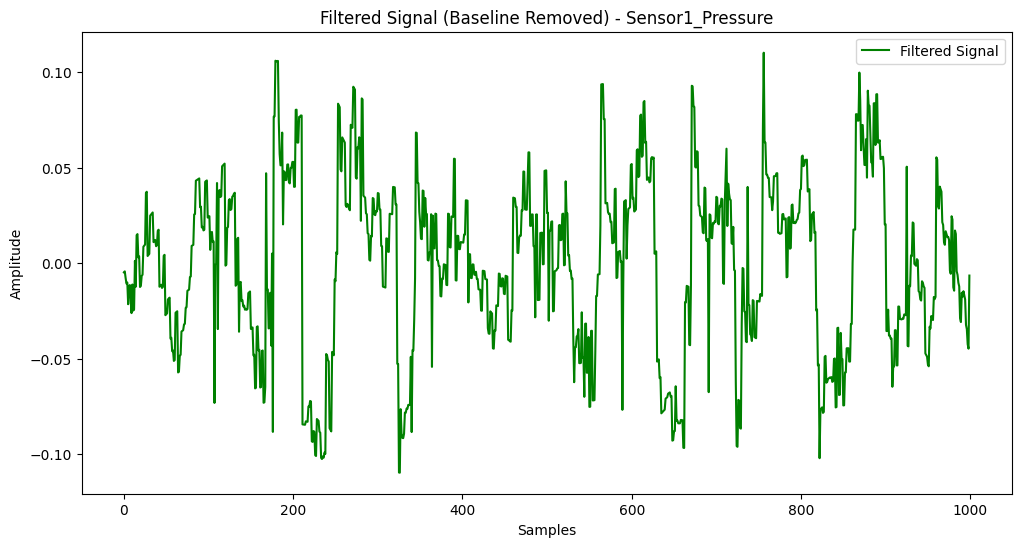

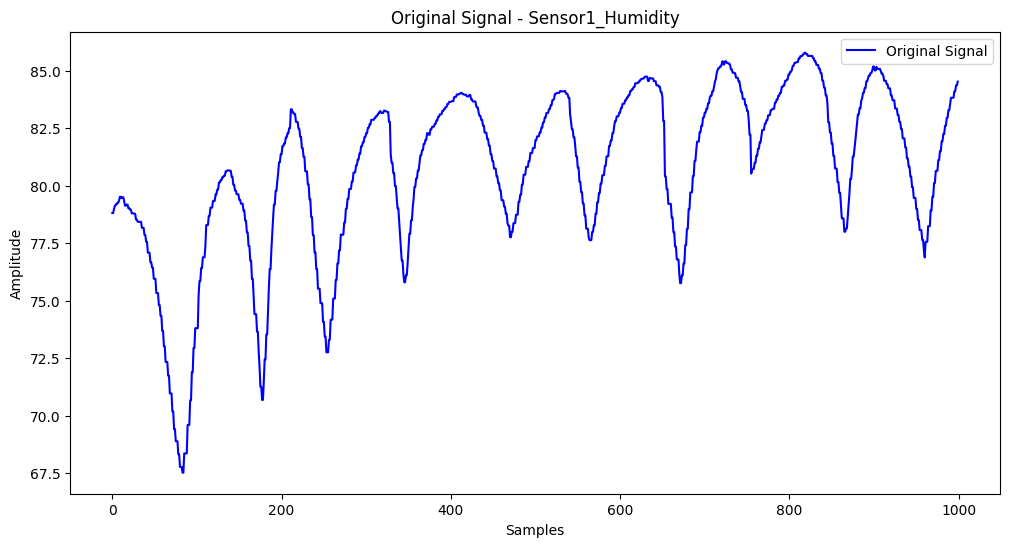

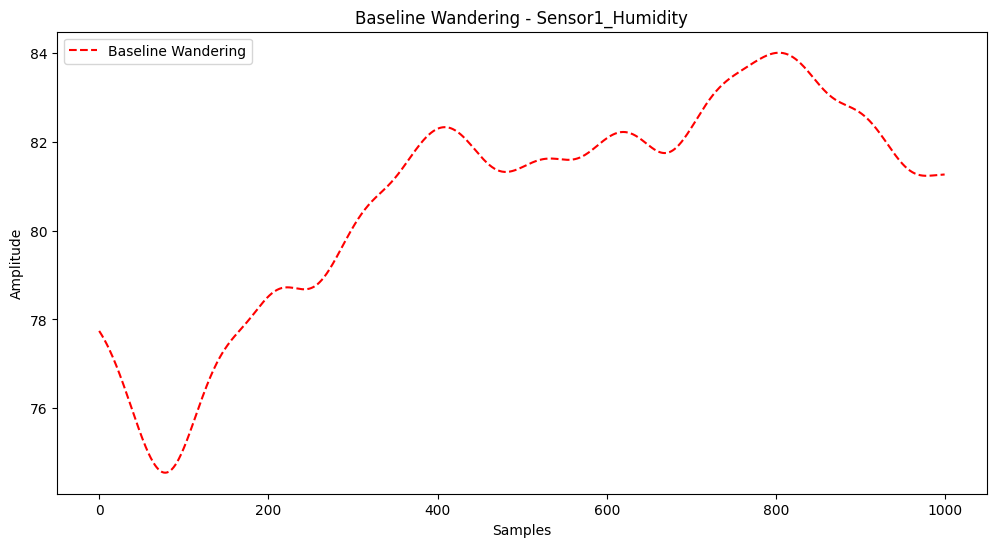

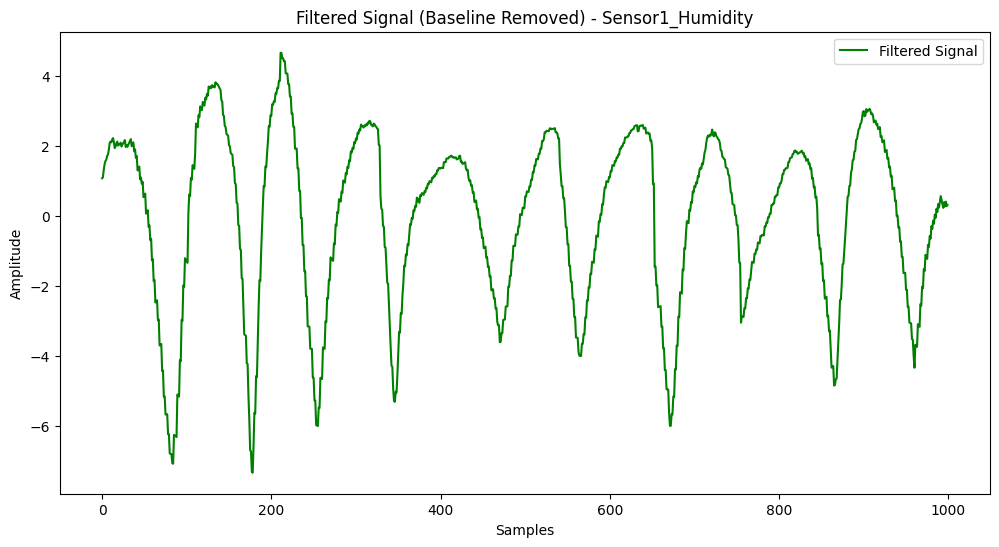

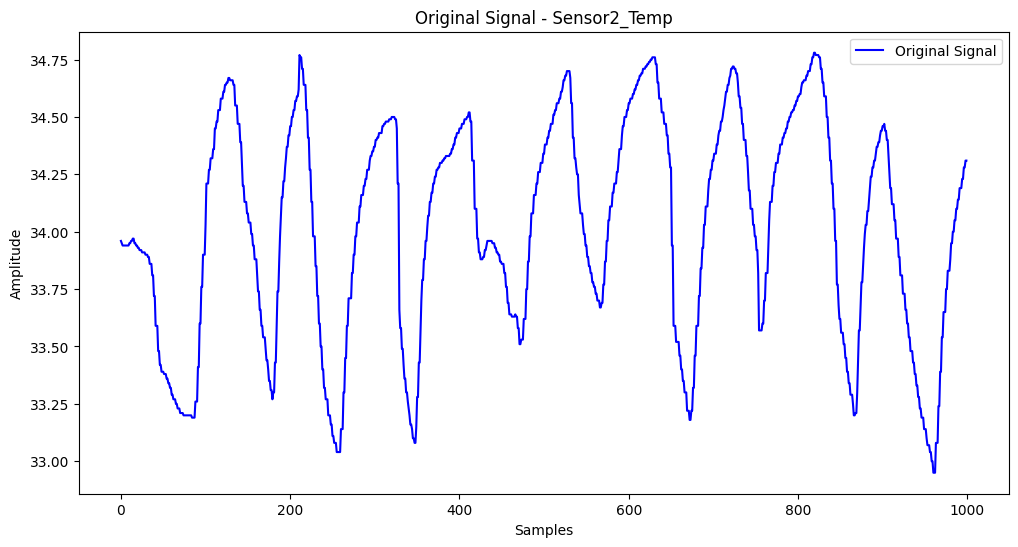

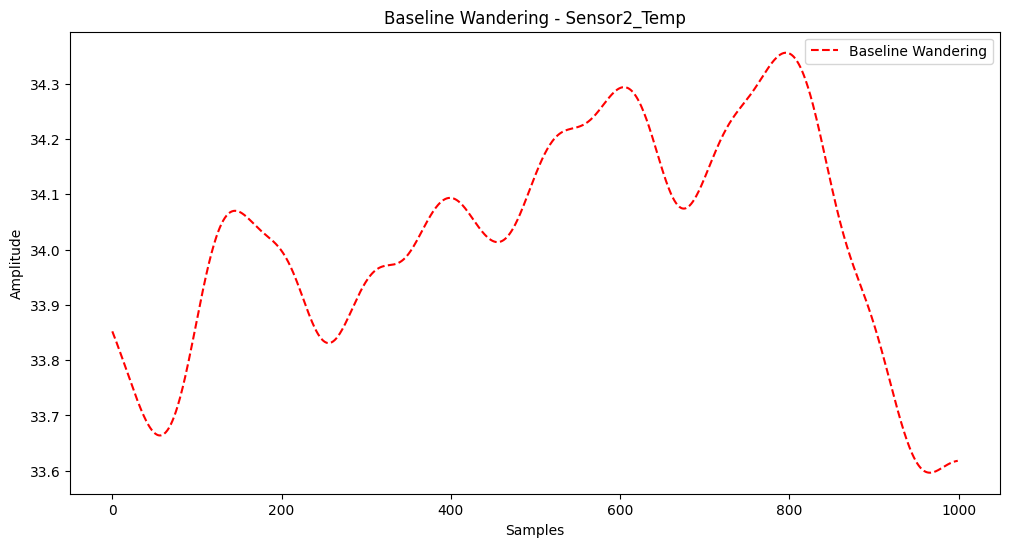

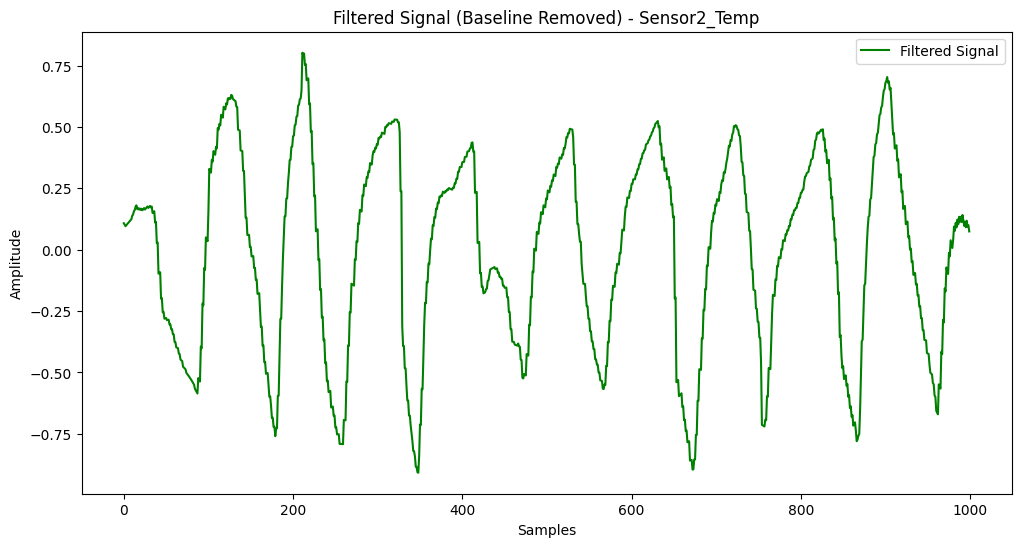

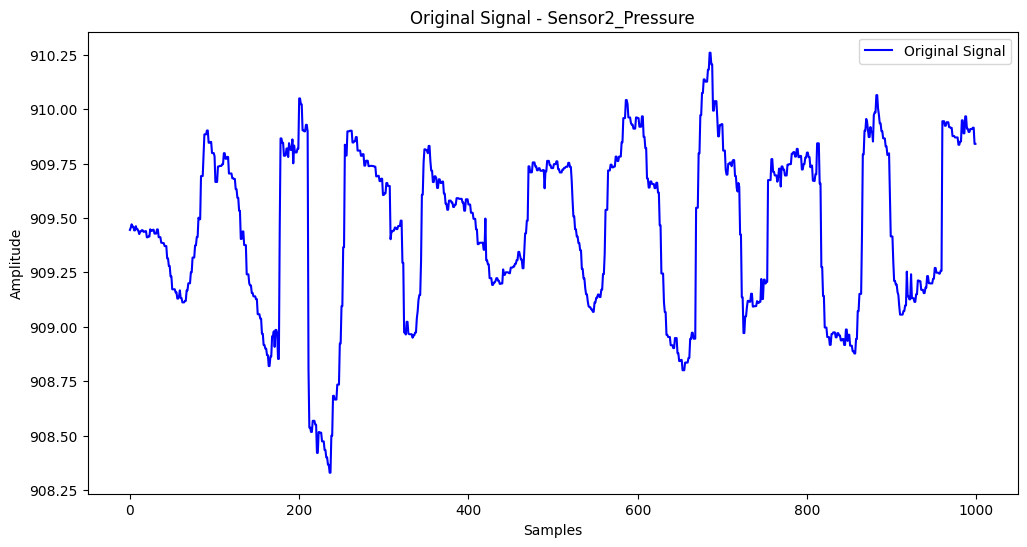

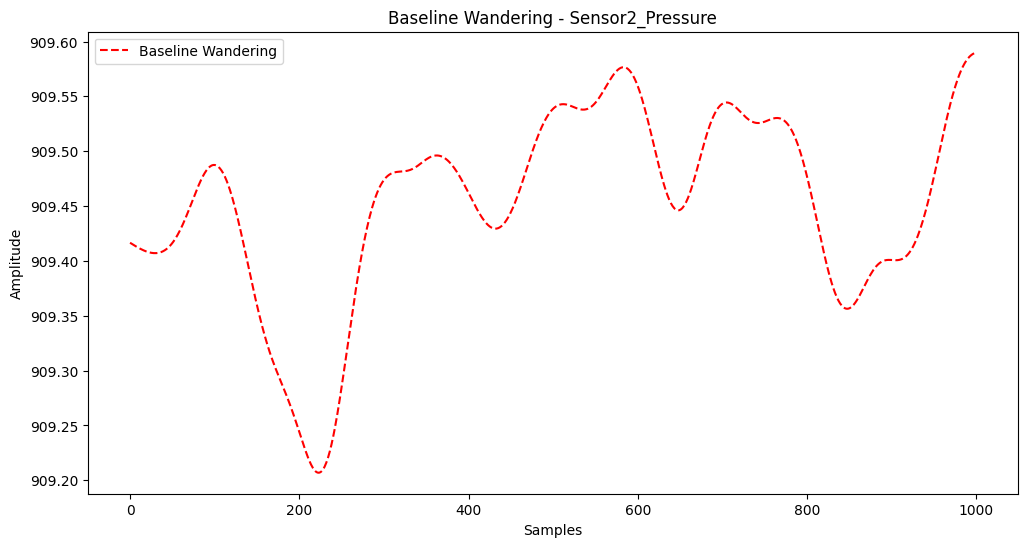

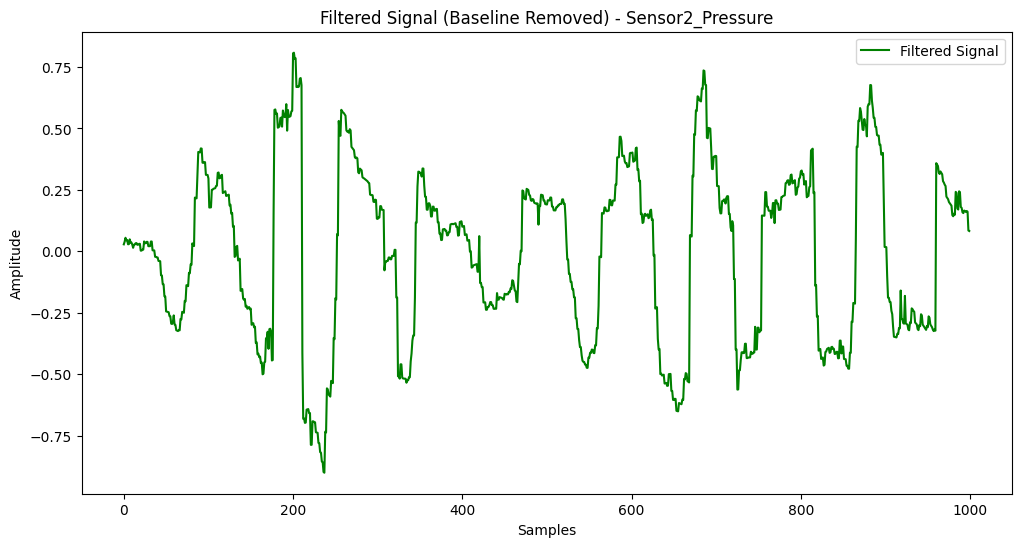

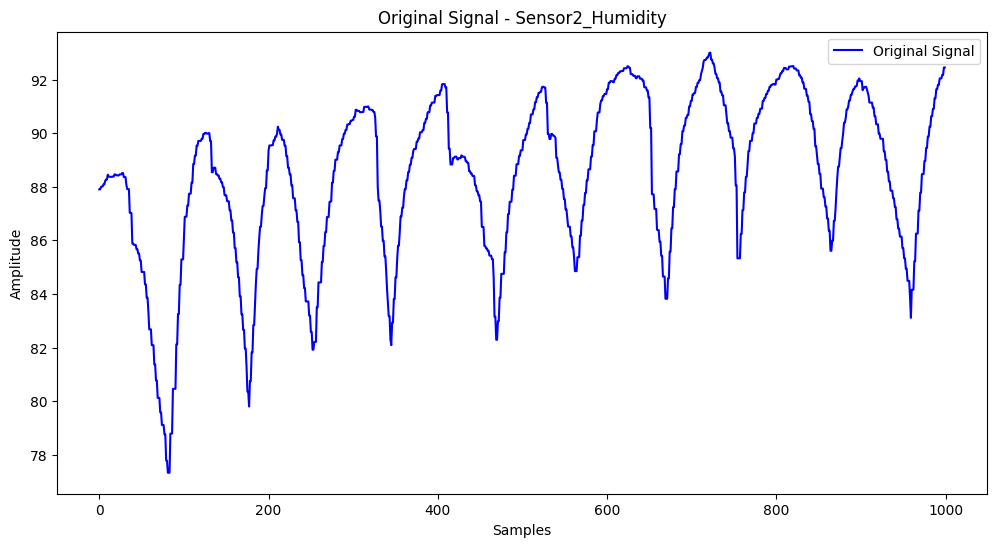

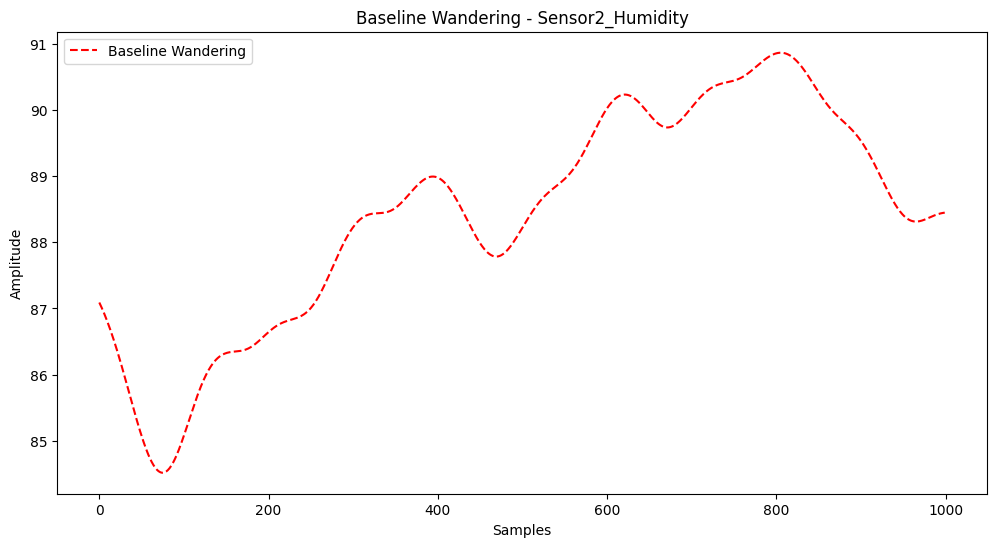

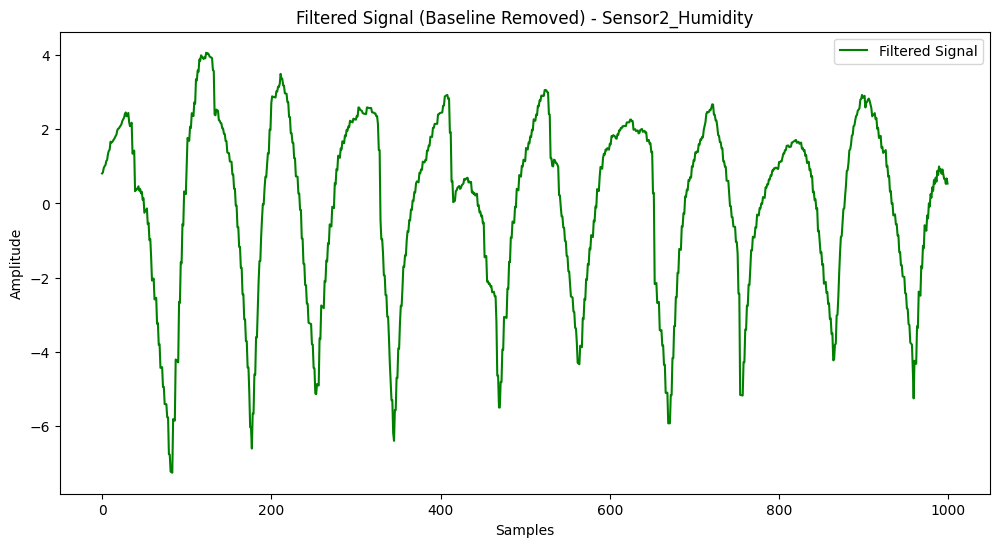

Epoch 1/100
784/784 [==============================] - 14s 12ms/step - loss: 0.2056 - val_loss: 1.4991e-18
Epoch 2/100
784/784 [==============================] - 9s 12ms/step - loss: 0.1841 - val_loss: 6.4600e-24
Epoch 3/100
784/784 [==============================] - 8s 11ms/step - loss: 0.1835 - val_loss: 0.0000e+00
Epoch 4/100
784/784 [==============================] - 9s 12ms/step - loss: 0.1830 - val_loss: 0.0000e+00
Epoch 5/100
784/784 [==============================] - 9s 12ms/step - loss: 0.1831 - val_loss: 0.0000e+00
Epoch 6/100
784/784 [==============================] - 9s 11ms/step - loss: 0.1829 - val_loss: 0.0000e+00
Epoch 7/100
784/784 [==============================] - 9s 12ms/step - loss: 0.1827 - val_loss: 0.0000e+00
Epoch 8/100
784/784 [==============================] - 13s 17ms/step - loss: 0.1828 - val_loss: 8.5231e-31
Epoch 9/100
784/784 [==============================] - 13s 16ms/step - loss: 0.1827 - val_loss: 2.4481e-25
Epoch 10/100
784/784 [=====================

In [ ]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Function to select multiple files
def load_files():
    root = tk.Tk()
    root.withdraw()
    file_paths = filedialog.askopenfilenames(title="Select CSV files", filetypes=[("CSV files", "*.csv")])
    return file_paths

# High-pass filter for baseline wandering removal
def high_pass_filter(signal, fs=19.62, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

# Low-pass filter for baseline wandering extraction
def low_pass_filter(signal, fs=19.62, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

# Outlier removal using Z-score
def remove_outliers(signal, threshold=3):
    z_scores = zscore(signal)
    filtered_signal = np.where(np.abs(z_scores) > threshold, np.median(signal), signal)
    return filtered_signal

# Function to compute metrics (Updated to handle classification properly)
def calculate_metrics(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred >= threshold).astype(int)  # Convert continuous values to binary
    y_true = (y_true >= threshold).astype(int)  # Ensure y_true is also binary

    accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
    specificity = recall_score(y_true.flatten(), y_pred.flatten(), pos_label=0, zero_division=1)
    f1 = f1_score(y_true.flatten(), y_pred.flatten(), zero_division=1)
    loss = np.mean((y_true - y_pred) ** 2)
    return accuracy, specificity, f1, loss

# Load datasets
file_paths = load_files()
if file_paths:
    dataframes = [pd.read_csv(file) for file in file_paths]
    df = pd.concat(dataframes, ignore_index=True)

    print("\nDatasets Loaded Successfully!\n")
    dataset_info = pd.DataFrame({
        "File Name": [file.split("/")[-1] for file in file_paths],
        "Rows": [len(pd.read_csv(file)) for file in file_paths],
        "Columns": [len(pd.read_csv(file).columns) for file in file_paths]
    })
    print(dataset_info)

    numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    
    if not numeric_columns:
        print("No numeric columns found in the dataset.")
    else:
        for col in numeric_columns:
            signal = df[col].fillna(0)[:1000]  # First 1000 samples
            
            # Plot original signal
            plt.figure(figsize=(12, 6))
            plt.plot(signal, label="Original Signal", color='b')
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.title(f"Original Signal - {col}")
            plt.legend()
            plt.show()

            # Detect and remove baseline wandering
            baseline_wandering = low_pass_filter(signal)
            filtered_signal = high_pass_filter(signal)
            
            # Plot baseline wandering
            plt.figure(figsize=(12, 6))
            plt.plot(baseline_wandering, label="Baseline Wandering", color='r', linestyle='dashed')
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.title(f"Baseline Wandering - {col}")
            plt.legend()
            plt.show()

            # Plot filtered signal
            plt.figure(figsize=(12, 6))
            plt.plot(filtered_signal, label="Filtered Signal", color='g')
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.title(f"Filtered Signal (Baseline Removed) - {col}")
            plt.legend()
            plt.show()

        # Prepare dataset for training
        scaler = MinMaxScaler()
        processed_data = scaler.fit_transform(df[numeric_columns].fillna(0))

        X, y = [], []
        seq_length = 10
        for i in range(len(processed_data) - seq_length):
            X.append(processed_data[i:i+seq_length])
            y.append(processed_data[i+seq_length])
        X, y = np.array(X), np.array(y)

        train_size = int(0.8 * len(X))
        X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

        # Build LSTM Model (Updated with sigmoid activation for binary classification)
        lstm_model = Sequential([
            LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(numeric_columns))),
            LSTM(50, activation='relu'),
            Dense(len(numeric_columns), activation='sigmoid')  # Using sigmoid for binary classification
        ])
        lstm_model.compile(optimizer='adam', loss='binary_crossentropy')
        history_lstm = lstm_model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

        # Predictions
        y_pred_lstm = lstm_model.predict(X_test)
        lstm_acc, lstm_spec, lstm_f1, lstm_loss = calculate_metrics(y_test, y_pred_lstm)

        # Build Transformer Model
        class TransformerModel(nn.Module):
            def __init__(self, input_dim):
                super(TransformerModel, self).__init__()
                self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=2, dim_feedforward=64, batch_first=True)
                self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
                self.fc = nn.Linear(input_dim, input_dim)

            def forward(self, x):
                x = self.transformer_encoder(x)
                return torch.sigmoid(self.fc(x[:, -1, :]))  # Sigmoid for binary classification

        transformer_model = TransformerModel(input_dim=len(numeric_columns))
        criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
        optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)

        transformer_losses = []
        for epoch in range(100):
            optimizer.zero_grad()
            X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
            y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
            output = transformer_model(X_train_tensor)
            loss = criterion(output, y_train_tensor)
            loss.backward()
            optimizer.step()
            transformer_losses.append(loss.item())

        # Predictions
        y_pred_transformer = transformer_model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()
        trans_acc, trans_spec, trans_f1, trans_loss = calculate_metrics(y_test, y_pred_transformer)

        # Model Performance Table
        model_performance = pd.DataFrame({
            "Model": ["LSTM", "Transformer"],
            "Loss": [lstm_loss, trans_loss],
            "Accuracy": [lstm_acc, trans_acc],
            "F1 Score": [lstm_f1, trans_f1],
            "Specificity": [lstm_spec, trans_spec]
        })
        print("\nModel Performance Metrics Table:\n", model_performance)

else:
    print("No file selected. Please upload a valid dataset.")
